In [1]:
from pathlib import Path
import sys
sys.path.append('../')
from pma_open import *


#My image
file_path = '../Dropbox Files/hel1.pma'
image_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame.png"
image = io.imread(image_path, as_gray=True)

#Chanel image paths
CH1_img_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame_CH1.png"
CH2_img_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame_CH2.png"

good_peaks_1,_ = good_peak_finder(CH1_img_path)
good_peaks_2_new,_ = good_peak_finder(CH2_img_path, sigma=2, block_size=16, scaler_percent=10, boarder=10, max_rad=3)

# Move good_peaks_1 to CH2 to display full image
good_peaks_1_CH2 = shift_peaks(good_peaks_1)
good_peaks_2_CH2 = shift_peaks(good_peaks_2_new)

# Poly Mapping
CH1_peaks_10= np.array([[14, 190], [308, 10], [493, 131], [115, 168], [273, 61], [55, 59], [179, 41], [234, 157], [365, 161], [502, 43]])
CH2_peaks_10 = np.array([[18, 449], [311, 269], [492, 388], [119, 427], [276, 319], [60, 318], [183, 300], [236, 416], [364, 419], [501, 301]])

params_x_man_10, params_y_man_10 = find_polyfit_params(CH1_peaks_10, CH2_peaks_10, degree=3)
mapped_peaks_10 = apply_polyfit_params(good_peaks_1, params_x_man_10, params_y_man_10).astype(np.uint16)
poly_pair_count_tol4_10, poly_pair_arr_CH1_tol4_10, poly_pair_arr_CH2_tol4_10 = find_polyfit_pairs(mapped_peaks_10, good_peaks_1, tolerance=4)

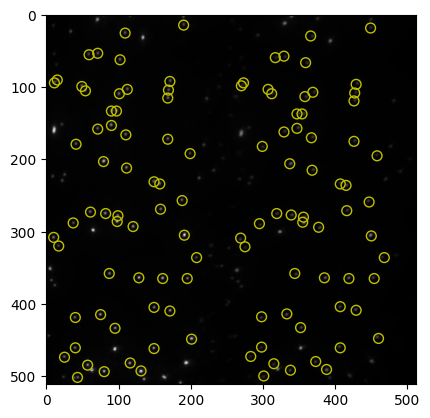

In [2]:
fig, ax = plt.subplots()
plt.imshow(image, cmap='gray')
ax.scatter(poly_pair_arr_CH1_tol4_10[:,1], poly_pair_arr_CH1_tol4_10[:,0], facecolors='none', edgecolors='y', s=50, label='CH1')
ax.scatter(poly_pair_arr_CH2_tol4_10[:,1], poly_pair_arr_CH2_tol4_10[:,0], facecolors='none', edgecolors='y', s=50, label='CH2')
plt.show()

# Calculate Static Global Background. 
#### Static-> Based on the average frame data only
#### Global -> uniform across the frame

In [3]:
circle_array_CH1 = draw_circle(4, poly_pair_arr_CH1_tol4_10[:,1], poly_pair_arr_CH1_tol4_10[:,0], image.shape[0])
circle_array_CH2 = draw_circle(4, poly_pair_arr_CH2_tol4_10[:,1], poly_pair_arr_CH2_tol4_10[:,0], image.shape[0])
circle_array_new = circle_array_CH1 + circle_array_CH2

mask_new = (circle_array_new == [255, 255, 0]).all(axis=-1)
if image.ndim == 2:
    image_3d = np.repeat(image[..., np.newaxis], 3, -1)
elif image.ndim==3 and image.shape[2]==3:
    image_3d = image
image_3d[mask_new] = [255, 255, 0]

In [14]:
#in stage 0 we are making sure we are getting the total of all peaks
def static_global_background_0(input_array, radius, y_centre_arr, x_centre_arr):
    all_peaks_intensity = 0
    pixel_count = 0
    #filling in the circle
    for y_centre, x_centre in zip(y_centre_arr, x_centre_arr):
        for i in range(x_centre - radius, x_centre+ radius + 1):
            for j in range(y_centre - radius, y_centre + radius + 1):
                if (i - x_centre) ** 2 + (j - y_centre) ** 2 < radius ** 2:
                    all_peaks_intensity += int(input_array[i][j][0])
                    pixel_count += 1
        

    return all_peaks_intensity, pixel_count

In [15]:
total_peak_intensity, pixel_count = static_global_background_0(image_3d, 4, np.concatenate((poly_pair_arr_CH1_tol4_10[:,0],poly_pair_arr_CH2_tol4_10[:,0])), np.concatenate((poly_pair_arr_CH1_tol4_10[:,1],poly_pair_arr_CH2_tol4_10[:,1])))
print(total_peak_intensity)
print(pixel_count)

76524
5040


# Testing this with our fake peaks!

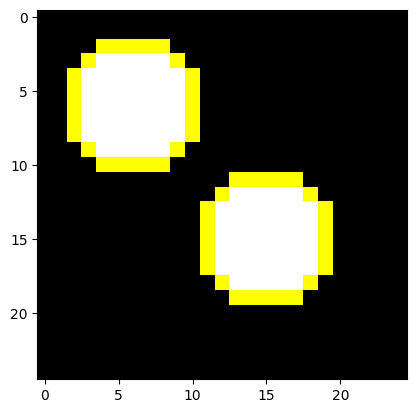

In [16]:
#Demonstates that we are selecting the pixels within the yellow circle outline
def fill_circle(input_array, radius, y_centre_arr, x_centre_arr, colour_fill = [255, 255, 255]):
    #setting background to [0,0,0]
    #filling in the circle
    for y_centre, x_centre in zip(y_centre_arr, x_centre_arr):
        for i in range(x_centre - radius, x_centre + radius + 1):
            for j in range(y_centre - radius, y_centre + radius + 1):
                if (i - x_centre) ** 2 + (j - y_centre) ** 2 < radius ** 2:
                    input_array[i, j] = colour_fill
    
    return input_array
radius = 4
background_dim= 25
x_cen = np.array([6, 15])
y_cen = np.array([6, 15])
background_array = draw_circle(radius, y_cen, x_cen, background_dim)
circle_array = fill_circle(background_array, radius, y_cen, x_cen)
plt.imshow(circle_array)

In [18]:
total_peak_intensity_circle, pixel_count_circle = static_global_background_0(circle_array, 4, y_cen, x_cen)
print(f"Total peak intensity: {total_peak_intensity_circle}")
print(45*2*255)
print(f"Total arr: {pixel_count_circle}")
print(45*2)

Total peak intensity: 22950
22950
Total arr: 90
90


# This code works so far so we should continue!
#### Add up the entire pixel intensity of the frame
#### Take away the total pixel intensity of the peaks
#### divide by the number of total pixels 512*512
#### this is the number we should take away from every pixel value!